In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.covariance import LedoitWolf
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import iisignature
import os
import json
from scipy.cluster.hierarchy import linkage, dendrogram


data location: https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data Loading

In [ ]:
data = pd.read_excel('/content/drive/MyDrive/ML Code/49_Industry_Portfolios_Daily.xlsx')

In [ ]:
# value weighted return data
data = data.rename(columns={'Unnamed: 0': 'Date'})
data['Date'] = pd.to_datetime(data['Date'].astype(int), format='%Y%m%d')
data = data.set_index('Date')

# get latest 2 year data
latest_date = data.index.max()
cutoff_date = latest_date - pd.DateOffset(years=2)
data_2y = data.loc[cutoff_date:]
data_2y = data_2y / 100.0

In [ ]:
data_2y

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
Date,,,,,,,,,,,,,,,,,,,,,
2023-07-31,0.0051,-0.0059,-0.0098,-0.0112,-0.0016,0.0304,0.0162,0.0152,-0.0027,0.0114,...,-0.0028,-0.0008,0.0036,0.0058,0.0048,0.0060,0.0038,0.0094,0.0006,0.0030
2023-08-01,-0.0076,-0.0031,-0.0020,-0.0055,-0.0114,-0.0018,-0.0039,-0.0010,-0.0013,-0.0058,...,-0.0073,-0.0142,0.0029,-0.0094,-0.0077,-0.0035,0.0001,0.0036,-0.0017,-0.0021
2023-08-02,0.0034,0.0087,0.0012,0.0052,-0.0066,-0.0167,-0.0186,-0.0060,0.0034,-0.0158,...,-0.0139,-0.0085,-0.0025,-0.0145,-0.0082,-0.0122,0.0060,-0.0065,-0.0122,-0.0026
2023-08-03,-0.0038,-0.0061,0.0001,-0.0059,-0.0055,-0.0049,-0.0016,0.0051,0.0015,0.0147,...,0.0176,-0.0102,0.0003,0.0044,-0.0044,0.0062,0.0011,-0.0115,0.0022,0.0034
2023-08-04,0.0062,-0.0084,-0.0207,-0.0106,-0.0105,-0.0101,0.0026,0.0082,-0.0081,-0.0023,...,-0.0124,0.0017,-0.0124,0.0282,-0.0091,-0.0019,-0.0052,-0.0091,-0.0010,-0.0088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-25,0.0029,0.0033,0.0037,-0.0059,0.0004,0.0098,0.0033,0.0058,0.0011,0.0101,...,-0.0008,0.0087,0.0031,0.0005,0.0132,0.0054,0.0111,0.0173,0.0060,0.0038
2025-07-28,-0.0128,-0.0114,-0.0138,-0.0137,-0.0192,0.0048,-0.0045,-0.0045,-0.0089,0.0055,...,-0.0103,0.0007,-0.0050,0.0029,-0.0083,-0.0035,-0.0120,-0.0047,-0.0046,-0.0044
2025-07-29,0.0089,0.0044,0.0179,0.0173,0.0256,-0.0127,-0.0077,-0.0045,-0.0085,-0.0061,...,-0.0048,-0.0287,-0.0001,-0.0029,-0.0036,-0.0059,-0.0163,0.0482,0.0020,-0.0063


### Helper Functions

In [ ]:
# def calculate_log_returns(data):
#     """
#     Calculates the daily log returns of a DataFrame of prices.
#     """
#     return np.log(data / data.shift(1)).dropna()

# def get_rolling_windows(data, window_size_years, step_months):
#     """
#     Generates rolling windows from a time series DataFrame.
#     """
#     start_date = data.index.min()
#     end_date = data.index.max()
#     window_size = pd.DateOffset(years=window_size_years)
#     step = pd.DateOffset(months=step_months)

#     current_start = start_date
#     while current_start + window_size <= end_date:
#         current_end = current_start + window_size
#         yield current_start, current_end, data.loc[current_start:current_end]
#         current_start += step


# euclidean optimal cluster number

# from sklearn.cluster import KMeans, AgglomerativeClustering
# from sklearn.metrics import silhouette_score
# from scipy.cluster.hierarchy import linkage, fcluster
# from scipy.spatial.distance import squareform
# import numpy as np

# def optimal_k_euclidean(X, ks=range(2,11), algo="kmeans"):
#     best_k, best_score = None, -1
#     for k in ks:
#         if algo == "kmeans":
#             labels = KMeans(n_clusters=k, n_init=50, random_state=42).fit_predict(X)
#         else:
#             labels = AgglomerativeClustering(n_clusters=k, linkage="ward").fit_predict(X)
#         s = silhouette_score(X, labels)
#         if s > best_score:
#             best_k, best_score = k, s
#     return best_k, best_score



In [ ]:
def get_optimal_clusters(X):
    """
    Finds the optimal number of clusters using the silhouette score.
    """
    best_n_clusters = 2
    best_score = -1
    for n_clusters in range(2, min(11, X.shape[0])):
        try:
            clusterer = AgglomerativeClustering(n_clusters=n_clusters)
            preds = clusterer.fit_predict(X)
            score = silhouette_score(X, preds)
            if score > best_score:
                best_score = score
                best_n_clusters = n_clusters
        except ValueError:
            continue
    return best_n_clusters


def leadlag(X):
    '''
    Returns lead-lag-transformed stream of X.

    Arguments:
        X: A list or pandas Series.

    Returns:
        A list of points on the plane, representing the
        lead-lag transformed stream of X.
    '''
    # Convert pandas Series to a simple list of values if necessary
    if isinstance(X, pd.Series):
        X = X.tolist()

    l = []
    for j in range(2 * len(X) - 1):
        i1 = j // 2
        i2 = j // 2
        if j % 2 != 0:
            i1 += 1
        l.append((X[i1], X[i2]))
    return l


def plot_correlation_clusters(correlation_matrix, labels, window_start, window_end, title_prefix):
    """
    Plots the clustered correlation matrix.
    """
    plt.figure(figsize=(12, 10))
    sorted_indices = np.argsort(labels)
    sorted_corr = correlation_matrix.iloc[sorted_indices, sorted_indices]

    sns.heatmap(sorted_corr, cmap='viridis', annot=False)

    unique_labels, counts = np.unique(labels, return_counts=True)
    tick_locations = np.cumsum(counts) - 0.5
    for loc in tick_locations[:-1]:
        plt.axhline(y=loc, color='white', linewidth=2)
        plt.axvline(x=loc, color='white', linewidth=2)

    plt.title(f'{title_prefix}: {window_start.date()} to {window_end.date()}')
    plt.show()


def plot_cluster_cumulative_returns(daily_returns_data, clusters, method_name, window_start, window_end):
    """
    Plots the cumulative returns for each cluster using arithmetic (value-weighted) returns.

    Args:
        daily_returns_data (pd.DataFrame): DataFrame of daily arithmetic returns for the window.
        clusters (dict): Dictionary of cluster assignments.
        method_name (str): Name of the clustering method for the title.
        window_start (datetime): Start date of the window.
        window_end (datetime): End date of the window.
    """
    # --- Convert daily returns into cumulative growth of $1 ---
    cumulative_returns = (1 + daily_returns_data).cumprod()

    for cluster_id, tickers in sorted(clusters.items()):
        if not tickers:
            continue

        plt.figure(figsize=(12, 7))
        cluster_cum_returns = cumulative_returns[tickers]

        # Plot each ticker with transparency
        for ticker in cluster_cum_returns.columns:
            plt.plot(cluster_cum_returns.index, cluster_cum_returns[ticker], alpha=0.4, label=ticker)

        # Calculate and plot the average cumulative return of the cluster
        average_cluster_return = cluster_cum_returns.mean(axis=1)
        plt.plot(
            average_cluster_return.index,
            average_cluster_return,
            color='black',
            linewidth=3,
            label='Cluster Average'
        )

        plt.title(f'{method_name} Cluster {cluster_id + 1} - Cumulative Returns\n({window_start.date()} to {window_end.date()})')
        plt.ylabel('Cumulative Return (Growth of $1)')
        plt.xlabel('Date')
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        # plt.legend()  # Uncomment if you want to show all tickers in legend
        plt.show()

def display_metrics_table(log_returns_data, index_log_returns, clusters, method_name, sentiment_scores):
    """
    Calculates and prints a table of performance metrics for each stock.

    Args:
        log_returns_data (pd.DataFrame): DataFrame of log returns for the stocks.
        index_log_returns (pd.Series): Series of log returns for the index.
        clusters (dict): Dictionary of cluster assignments.
        method_name (str): Name of the clustering method for the table title.
        sentiment_scores (dict): Dictionary of sentiment scores for each ticker.
    """
    metrics = []

    # Align index data with stock data
    aligned_index_returns = index_log_returns.reindex(log_returns_data.index).fillna(0)
    index_cum_return = np.exp(aligned_index_returns.sum()) - 1

    for cluster_id, tickers in sorted(clusters.items()):
        if not tickers:
            continue

        cluster_log_returns = log_returns_data[tickers]
        cluster_average_log_return = cluster_log_returns.mean(axis=1)
        cluster_avg_cum_return = np.exp(cluster_average_log_return.sum()) - 1


        for ticker in tickers:
            stock_returns = log_returns_data[ticker]

            # Cumulative Return
            cum_return = np.exp(stock_returns.sum()) - 1

            # Excess Returns
            excess_return_vs_cluster = cum_return - cluster_avg_cum_return
            excess_return_vs_index = cum_return - index_cum_return

            # Sharpe Ratio (assuming 0 risk-free rate)
            annualized_return = stock_returns.mean() * 252
            annualized_volatility = stock_returns.std() * np.sqrt(252)
            sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else 0

            # Tracking Error vs Cluster
            diff_vs_cluster = stock_returns - cluster_average_log_return
            te_vs_cluster = diff_vs_cluster.std() * np.sqrt(252)

            # Tracking Error vs Index
            diff_vs_index = stock_returns - aligned_index_returns
            te_vs_index = diff_vs_index.std() * np.sqrt(252)

            metrics.append({
                'Ticker': ticker,
                'Cluster': cluster_id + 1,
                'Sentiment': sentiment_scores.get(ticker, 'N/A'), # Get sentiment score
                'Sharpe Ratio': f"{sharpe_ratio:.2f}",
                'Cumulative Return': f"{cum_return:.2%}",
                'Excess Return vs Cluster': f"{excess_return_vs_cluster:.2%}",
                'Excess Return vs Index': f"{excess_return_vs_index:.2%}",
                'TE vs Cluster': f"{te_vs_cluster:.2%}",
                'TE vs Index': f"{te_vs_index:.2%}"
            })

    metrics_df = pd.DataFrame(metrics)
    # Reorder columns to place Sentiment near the Ticker
    cols = ['Ticker', 'Cluster', 'Sentiment', 'Sharpe Ratio', 'Cumulative Return',
            'Excess Return vs Cluster', 'Excess Return vs Index', 'TE vs Cluster', 'TE vs Index']
    metrics_df = metrics_df[cols]

    print(f"\n--- Performance Metrics: {method_name} Clusters ---")
    print(metrics_df.to_string(index=False))

def plot_signature_tsne_clusters(signatures_matrix, labels, tickers, window_start, window_end):
    """
    Performs t-SNE on signature data and plots the clusters.
    """
    # Perplexity should be less than the number of samples.
    perplexity_value = min(29, len(tickers) - 1)

    tsne = TSNE(n_components=2, perplexity=perplexity_value, random_state=42, n_iter=1000, init='pca', learning_rate='auto')
    tsne_components = tsne.fit_transform(signatures_matrix)

    tsne_df = pd.DataFrame(data=tsne_components, columns=['t-SNE 1', 't-SNE 2'])
    tsne_df['Cluster'] = labels
    tsne_df['Ticker'] = tickers

    plt.figure(figsize=(16, 12))
    sns.scatterplot(x='t-SNE 1', y='t-SNE 2', hue='Cluster', data=tsne_df, palette='viridis', s=150, legend='full')

    # Annotate points with ticker symbols using a more robust method
    for i, point in tsne_df.iterrows():
        plt.annotate(point['Ticker'],
                     (point['t-SNE 1'], point['t-SNE 2']),
                     textcoords="offset points",
                     xytext=(0,10), # Offset text by 10 points vertically
                     ha='center') # Center horizontally

    plt.title(f'Path Signature t-SNE Clusters: {window_start.date()} to {window_end.date()}', fontsize=16)
    plt.xlabel('t-SNE Component 1', fontsize=12)
    plt.ylabel('t-SNE Component 2', fontsize=12)
    plt.grid(True)
    plt.show()


### optimal clusters for hierarchy clustering

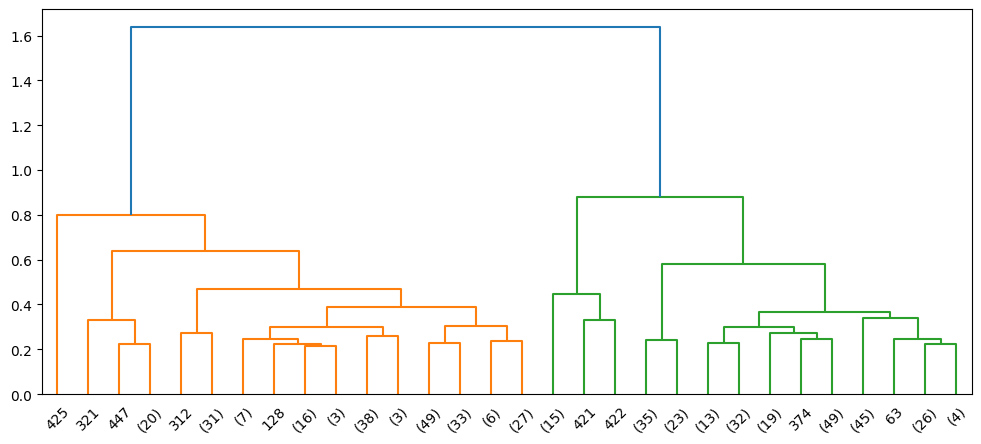

In [ ]:
Z = linkage(data_2y, method='ward')
plt.figure(figsize=(12, 5))
dendrogram(Z, truncate_mode='lastp', p=30)
plt.show()

### Ledoit-Wolf Coreelation Clustering


1. Ledoit-Wolf Correlation-Based Clustering:
Ledoit-Wolf Correlation Clusters:
  Cluster 1: Agric, Food, Soda, Beer, Smoke, Hshld, Hlth, MedEq, Drugs, Guns, Gold, Coal, Oil, Util, Telcm, Paper, Boxes, Insur
  Cluster 2: Toys, Fun, Books, Clths, Chems, Rubbr, Txtls, BldMt, Cnstr, Steel, FabPr, Mach, ElcEq, Autos, Aero, Ships, Mines, PerSv, BusSv, Hardw, Softw, Chips, LabEq, Trans, Whlsl, Rtail, Meals, Banks, RlEst, Fin, Other


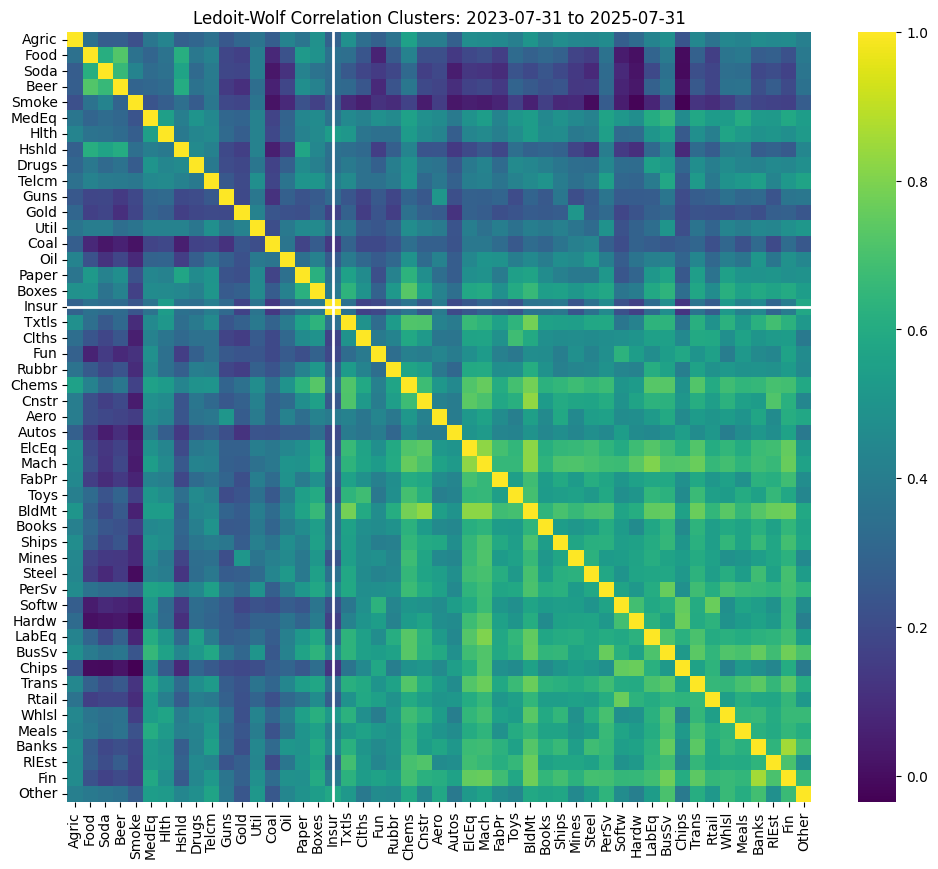

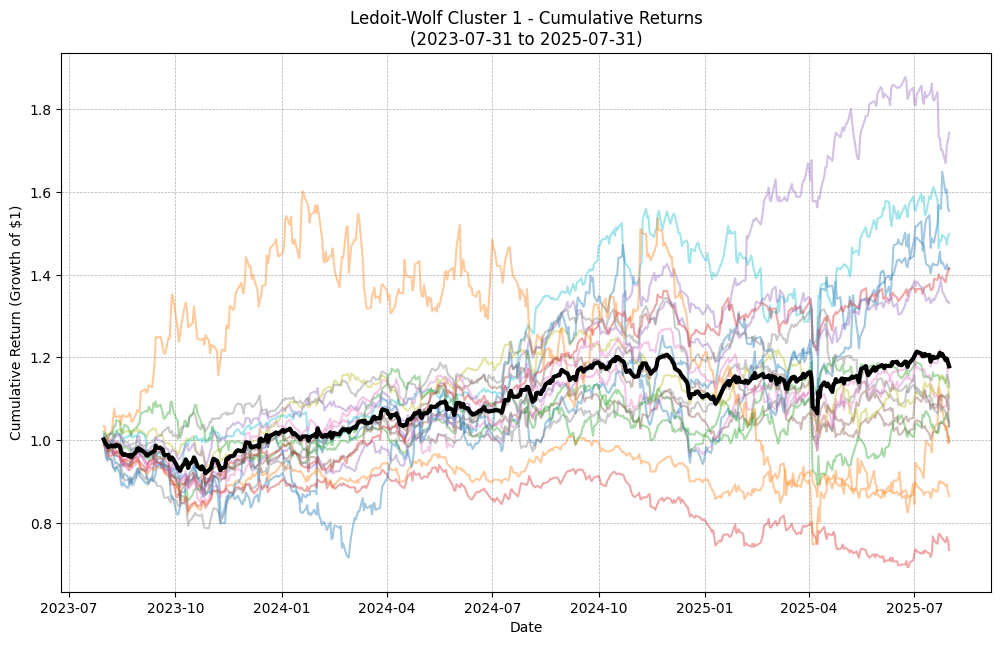

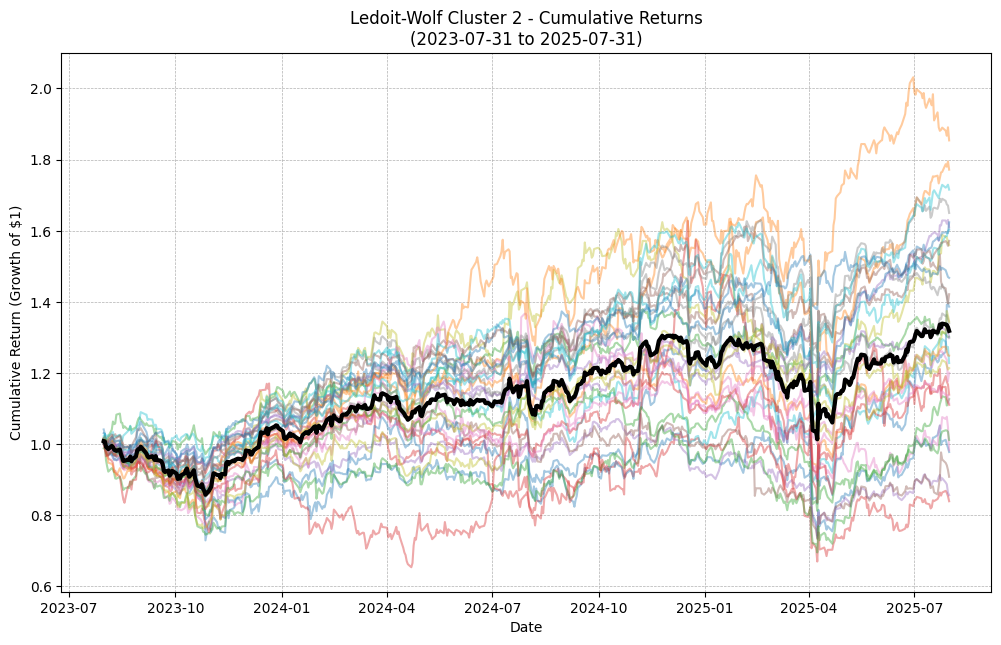


--- Performance Metrics: Ledoit-Wolf Clusters ---
Ticker  Cluster  Sentiment Sharpe Ratio Cumulative Return Excess Return vs Cluster Excess Return vs Index TE vs Cluster TE vs Index
 Agric        1          2         0.81            50.56%                   29.89%                 19.45%        19.69%      20.09%
  Food        1          2        -0.41           -11.59%                  -32.26%                -42.70%        11.31%      16.30%
  Soda        1          0         0.48            15.30%                   -5.37%                -15.81%        12.20%      17.28%
  Beer        1          2        -0.80           -24.23%                  -44.90%                -55.34%        14.05%      18.39%
 Smoke        1         -3         1.57            80.54%                   59.87%                 49.43%        17.02%      21.48%
 Hshld        1          0         0.06             1.69%                  -18.98%                -29.42%        11.42%      15.76%
  Hlth        1          

In [ ]:
    sentiment_scores_jan_2025 = {'Agric': 2, 'Food': 2,'Soda': 0,'Beer': 2,
                            'Smoke': -3,'Toys': -2, 'Fun': 2,'Books': 0,
                            'Hshld': 0,'Clths': -2,'Hlth': 2,'MedEq': 2,
                            'Drugs': 5,'Chems': 0,'Rubbr': 0,'Txtls': -2,
                            'BldMt': 2,'Cnstr': 3,'Steel': 0,'FabPr': 2,
                            'Mach': 2,'ElcEq': 2,'Autos': 0,'Aero': 5,
                            'Ships': 2, 'Guns': 5, 'Gold': 3,'Mines': 3,
                            'Coal': -2,'Oil': 3, 'Util': 0, 'Telcm': 0,
                            'PerSv': 0, 'BusSv': 2, 'Hardw': 0, 'Softw': 5,
                            'Chips': 5, 'LabEq': 2, 'Paper': -2, 'Boxes': 0,
                            'Trans': 0,'Whlsl': 0, 'Rtail': -2, 'Meals': 2,
                            'Banks': 0, 'Insur': 2,'RlEst': -3, 'Fin': 2,
                            'Other': 0
}

    final_results = {}

    # --- Method 1: Ledoit-Wolf Correlation Clustering ---
    print("\n1. Ledoit-Wolf Correlation-Based Clustering:")
    try:
        lw = LedoitWolf().fit(data_2y)
        cov_matrix = lw.covariance_
        std_devs = np.sqrt(np.diag(cov_matrix))
        stock_correlation = pd.DataFrame(cov_matrix / np.outer(std_devs, std_devs),
                                         index=data_2y.columns,
                                         columns=data_2y.columns)

        cluster_data_corr = stock_correlation.fillna(0).values
        n_clusters_corr = get_optimal_clusters(cluster_data_corr)
        clustering_corr = AgglomerativeClustering(n_clusters=n_clusters_corr, linkage='ward')
        labels_corr = clustering_corr.fit_predict(cluster_data_corr)

        clusters_corr = {i: [] for i in range(n_clusters_corr)}
        for i, ticker in enumerate(stock_correlation.columns):
            clusters_corr[labels_corr[i]].append(ticker)

        final_results['ledoit_wolf_clusters'] = {int(k): v for k, v in clusters_corr.items()}

        print("Ledoit-Wolf Correlation Clusters:")
        for cluster_id, tickers in sorted(clusters_corr.items()):
            print(f"  Cluster {cluster_id + 1}: {', '.join(tickers)}")

        window_start = data_2y.index.min()
        window_end = data_2y.index.max()

        index_window_returns = data_2y.mean(axis=1)

        plot_correlation_clusters(stock_correlation, labels_corr, window_start, window_end, "Ledoit-Wolf Correlation Clusters")
        plot_cluster_cumulative_returns(data_2y, clusters_corr, "Ledoit-Wolf", window_start, window_end)
        display_metrics_table(data_2y, index_window_returns, clusters_corr, "Ledoit-Wolf", sentiment_scores_jan_2025)


    except Exception as e:
        print(f"Could not perform Ledoit-Wolf clustering for this window: {e}")

### path signature clustering


2. Path Signature-Based Clustering:
Path Signature-Based Stock Clusters:
  Cluster 1: Toys, Hshld, Rubbr, Txtls, Autos, Coal, Oil, LabEq, Paper, Insur
  Cluster 2: Soda, Hlth, MedEq, Drugs, Steel, Mach, ElcEq, Mines, BusSv, Boxes, Trans, Meals
  Cluster 3: Agric, Books, BldMt, FabPr, Ships, Guns, Util, Telcm, PerSv, Whlsl, RlEst, Other
  Cluster 4: Smoke, Fun, Chips, Fin
  Cluster 5: Cnstr, Aero, Gold, Hardw, Softw, Rtail, Banks
  Cluster 6: Food, Beer, Clths, Chems


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


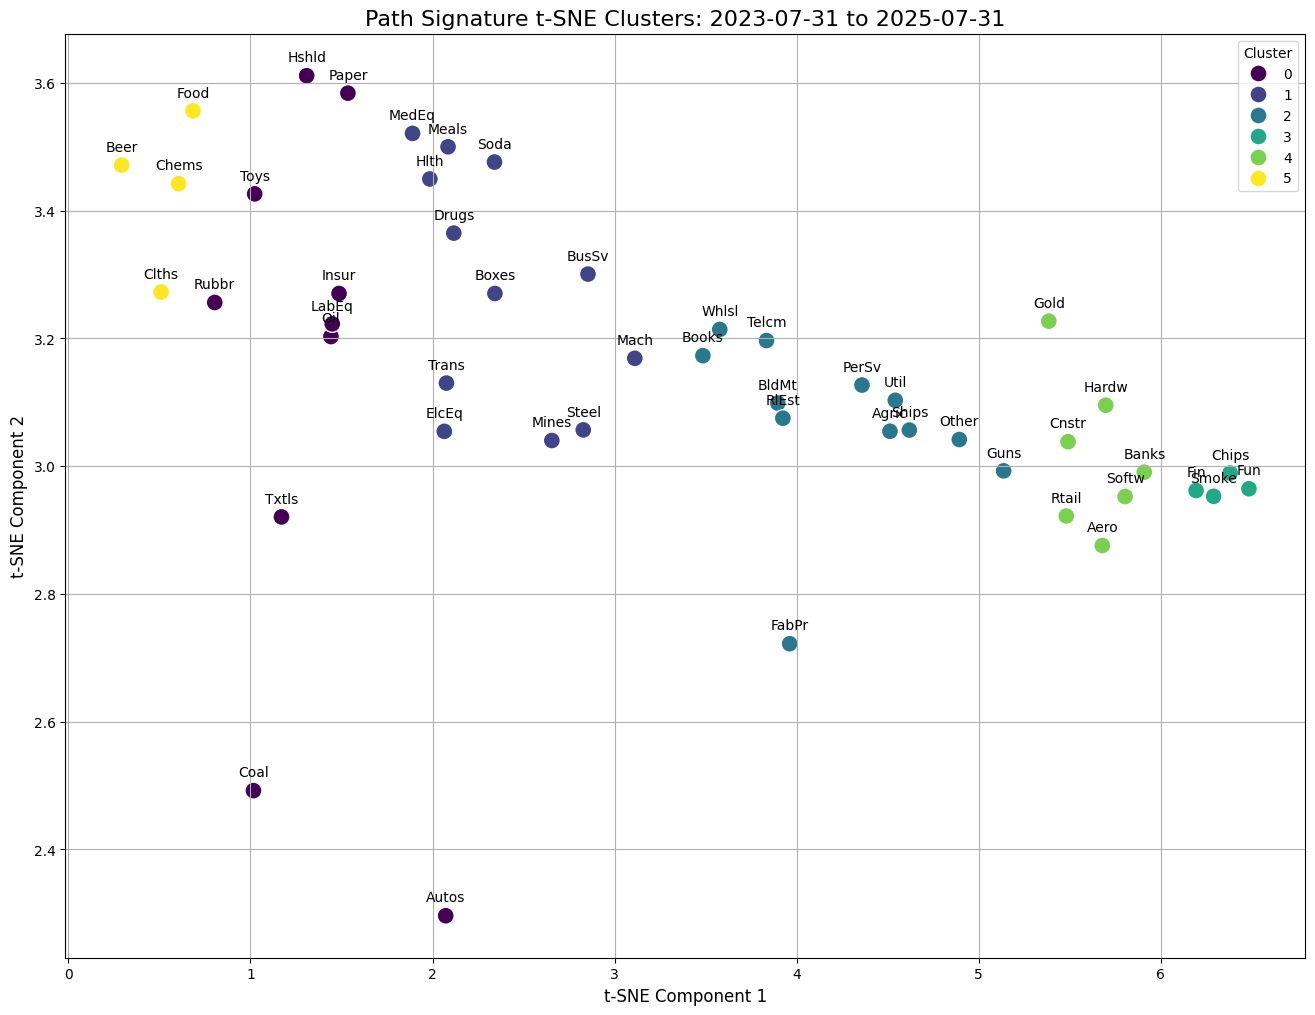

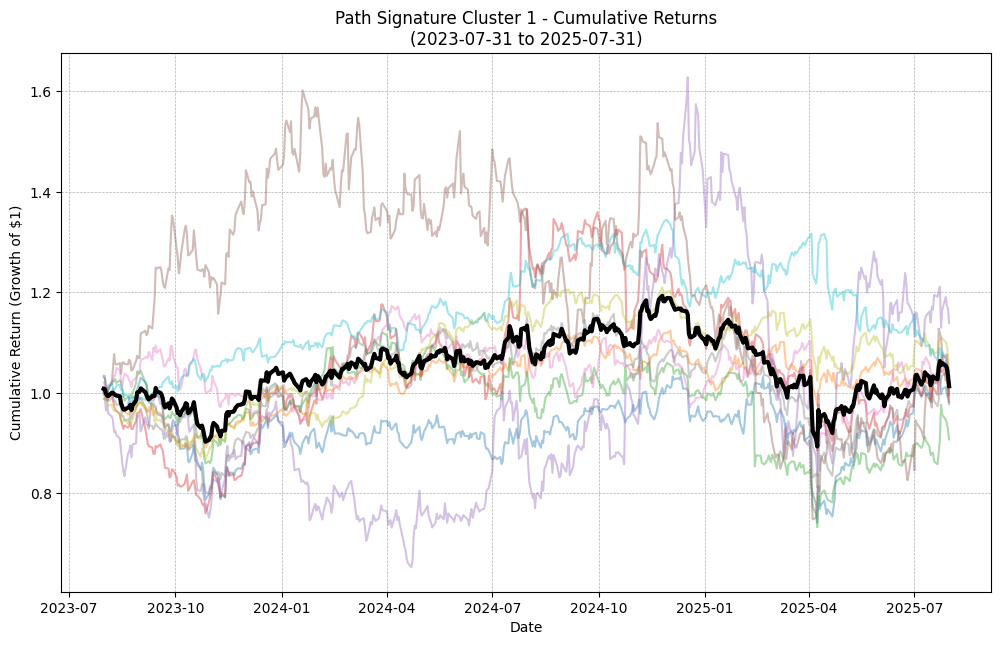

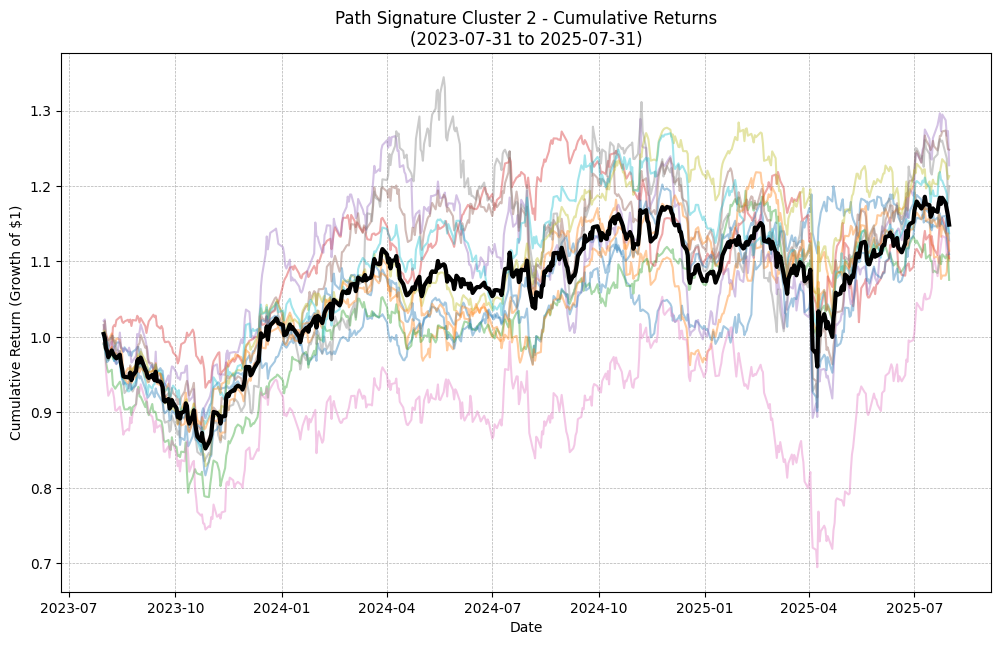

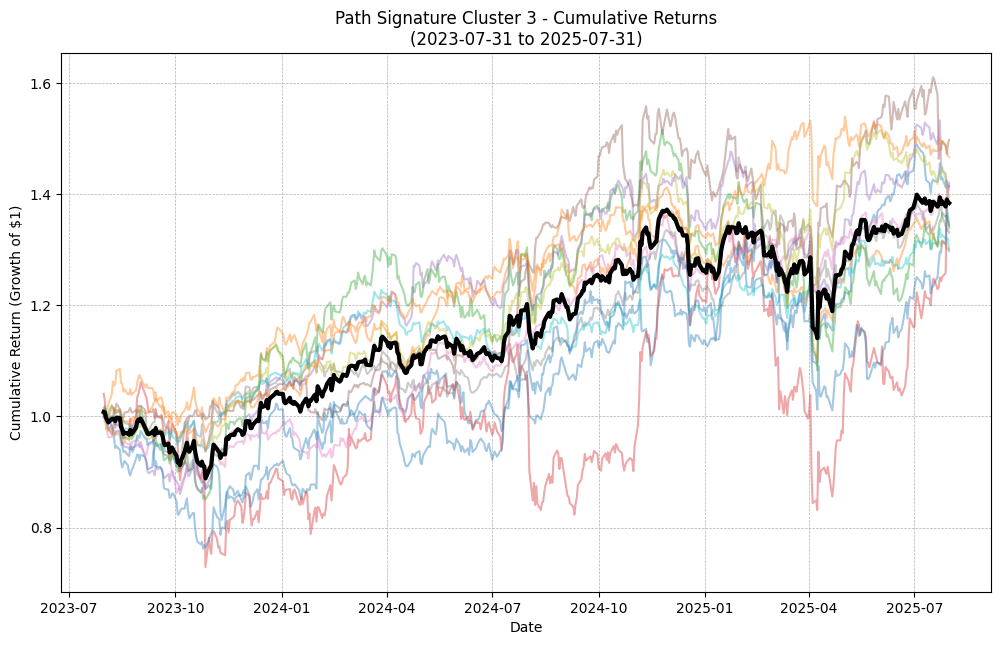

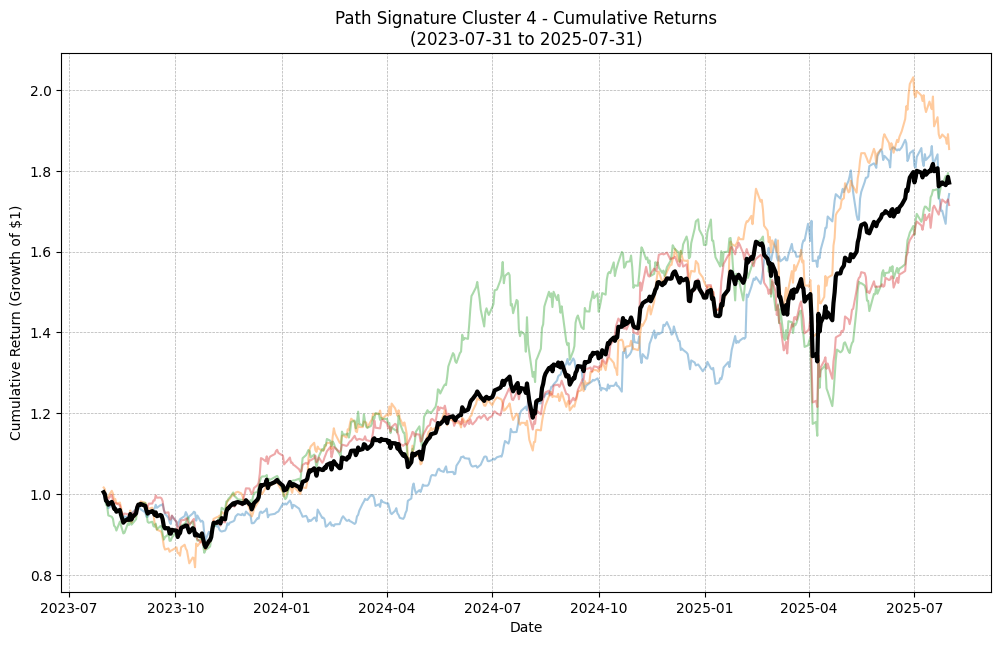

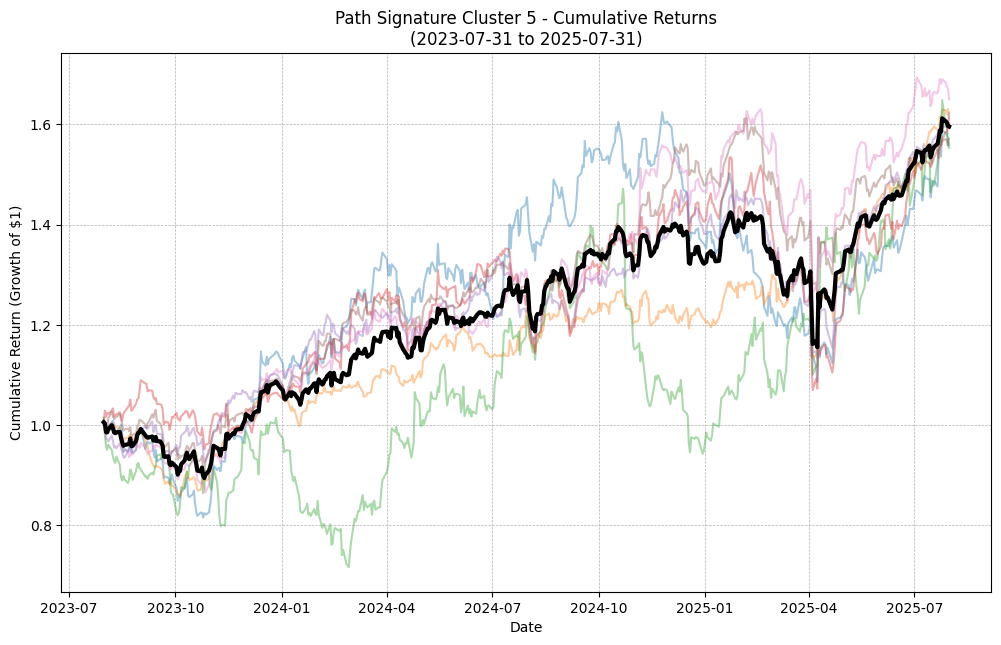

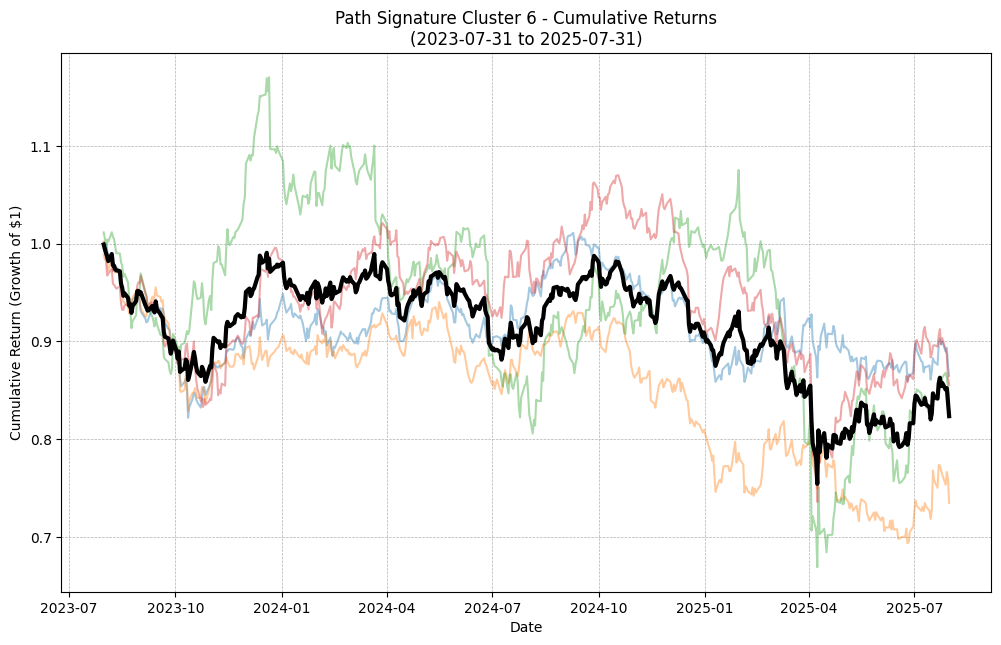

In [ ]:
    # --- Method 2: Path Signature Clustering ---
    print("\n2. Path Signature-Based Clustering:")
    try:
        signature_level = 4
        signatures = []
        tickers_in_window = data_2y.columns
        for ticker in tickers_in_window:
            # Get the raw price series for the current stock
            # simple return -> price index -> normalize to 1
            r = pd.Series(data_2y[ticker], dtype=float)
            normalized_prices = (1.0 + r).cumprod()
            normalized_prices = normalized_prices / normalized_prices.iloc[0]

            # Create the formal lead-lag path from the NORMALIZED price series
            path = leadlag(normalized_prices)

            # Compute the signature of the path
            signature = iisignature.sig(path, signature_level)
            signatures.append(signature)

        signatures_matrix = np.array(signatures)

        # Force a more varied number of clusters instead of using the optimal score
        n_clusters_sig = 6
        clustering_sig = AgglomerativeClustering(n_clusters=n_clusters_sig, linkage='ward')
        labels_sig = clustering_sig.fit_predict(signatures_matrix)

        clusters_sig = {i: [] for i in range(n_clusters_sig)}
        for i, ticker in enumerate(tickers_in_window):
            clusters_sig[labels_sig[i]].append(ticker)

        final_results['signature_clusters'] = {int(k): v for k, v in clusters_sig.items()}

        print("Path Signature-Based Stock Clusters:")
        for cluster_id, tickers in sorted(clusters_sig.items()):
            print(f"  Cluster {cluster_id + 1}: {', '.join(tickers)}")

        plot_signature_tsne_clusters(signatures_matrix, labels_sig, tickers_in_window, window_start, window_end)
        # The cumulative return plot should still use log returns (window_data) to be comparable
        plot_cluster_cumulative_returns(data_2y, clusters_sig, "Path Signature", window_start, window_end)
        # display_metrics_table(data_2y, index_window_returns, clusters_sig, "Path Signature", sentiment_scores_jan_2025)

    except Exception as e:
        print(f"Could not perform signature clustering for this window: {e}")

In [ ]:
n_clusters_sig = get_optimal_clusters(signatures_matrix)
n_clusters_sig


2